# Homework 9 for PUI2016
**Name:** Cheng Hou

**NetID:** ch3019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import datetime as dt
import statsmodels.api as sm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TIME SERIES ANALYSIS
## Goal: Find outliers, trends and periodicity in the MTA turnstile data

## Load Data

In [2]:
mtarides = np.load("MTA_Fare.npy").astype(float)
mtarides.shape

(600, 23, 194)

In [3]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

Replace the missing values that are inputted as **-1** by **NaN**

In [4]:
np.place(mtarides, mtarides==-1, np.nan)

Generate the date list corresponding to the data

In [5]:
start_date = dt.date(2010, 5, 21)
end_date = dt.date(2014, 2, 21)
datelist = pd.date_range(start_date, end_date, freq='w').tolist()

len(datelist)

196

### Task 1

In [6]:
df1 = np.nansum(np.nansum(mtarides, axis=0), axis=0)

In [7]:
tmean = np.nanmean(df1)
tstd = np.nanstd(df1)
thresholds = [tmean - 3*tstd, tmean + 3*tstd]
indx = np.where((df1<thresholds[0]) | (df1>thresholds[1]))

In [8]:
indx[0]

array([126])

In [9]:
datelist[indx[0][0]+1]

Timestamp('2012-10-28 00:00:00', offset='W-SUN')

We find out [**Hurricane Sandy Hit New York**](https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_New_York) should be the most prominent event.

Consider the MTA data only include 194 weeks. So we adjust the datelist based on the 126th week began at 2012-10-28.

In [10]:
datelist = datelist[1:195]

Figure plot

In [11]:
def datetostr(Date):
    return "{:%b %Y}".format(Date)
DatetoStr = np.vectorize(datetostr)

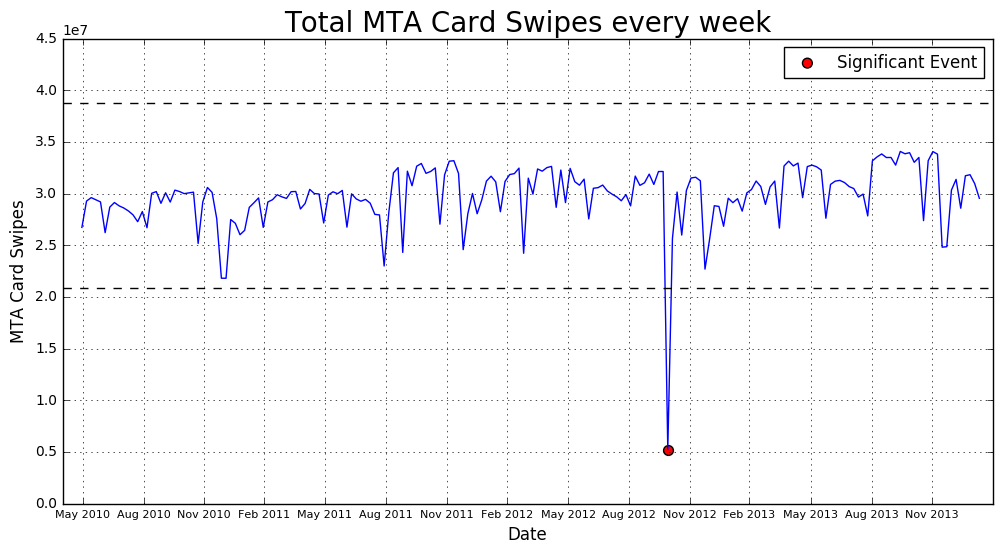

In [12]:
pl.figure(figsize = (12,6))
pl.plot(datelist, df1)
pl.scatter(datelist[indx[0][0]], df1[indx[0][0]], s=50, c='r', label='Significant Event')

daterange = pd.date_range(start_date, end_date, freq='3m').tolist()
pl.xticks(daterange, DatetoStr(daterange), fontsize=8)
pl.xlim(dt.date(2010,5,1), dt.date(2014,3,1))
pl.plot([dt.date(2010,5,1), dt.date(2014,3,1)], [thresholds[0], thresholds[0]], 'k--')
pl.plot([dt.date(2010,5,1), dt.date(2014,3,1)], [thresholds[1], thresholds[1]], 'k--')
pl.xlabel('Date', fontsize=12)
pl.ylabel('MTA Card Swipes', fontsize=12)
pl.title('Total MTA Card Swipes every week', fontsize=20)
pl.legend(loc='best', scatterpoints=1)
pl.grid(True)

### Task 2

In [13]:
df2 = pd.DataFrame(np.nansum(mtarides, axis=0).T, columns=ridetype)
df2_rollingmean = df2.rolling(10).mean()

In [14]:
def inttoth(n):
    if n%10==1:
        return str(n)+'st'
    elif n%10==2:
        return str(n)+'nd'
    elif n%10==3:
        return str(n)+'rd'
    else:
        return str(n)+'th'

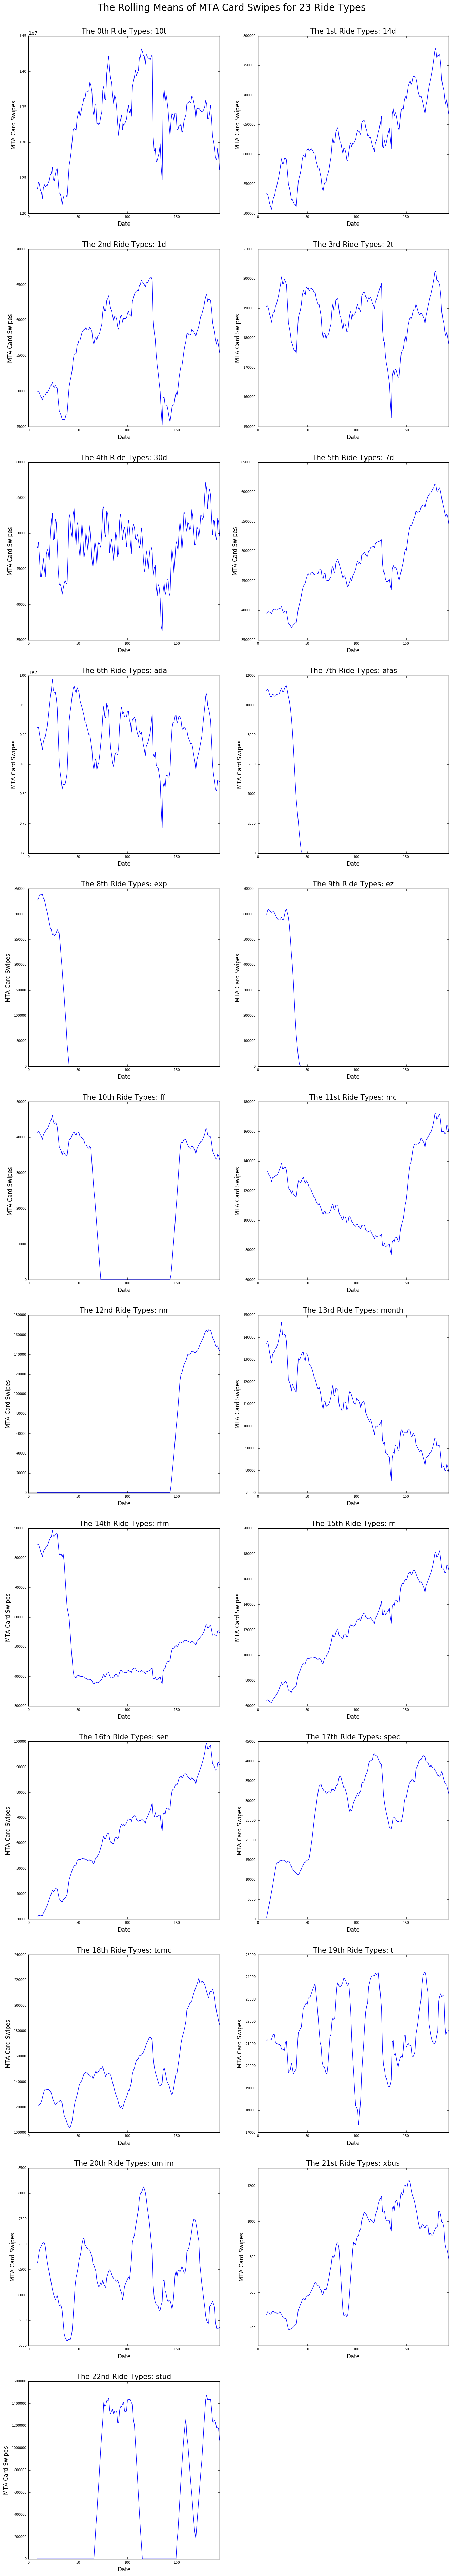

In [15]:
fig = pl.figure(figsize=(16,96))
pl.suptitle('The Rolling Means of MTA Card Swipes for 23 Ride Types', fontsize=20, y=0.91)
for i in range(23):
    ax = fig.add_subplot(12,2,i+1)
    ax = df2_rollingmean.iloc[:,i].plot(fontsize=7)
    ax.set_title('The {} Ride Types: {}'.format(inttoth(i), ridetype[i]), fontsize=15)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('MTA Card Swipes', fontsize=12)
pl.show()

From the plot, we find out that the rideship types of **14d, 7d, rr, sen, spec, tcmc, xbus** have steadily **increased** in popularity and the rideship types of **month** have steadily **decreased** in popularity.

In [16]:
tendlist = np.array(['14d', '7d', 'rr', 'sen', 'spec', 'tcmc', 'xbus', 'month'])

In [17]:
print("The ratio of usage in the first 10 and last 10 weeks:")
for col in tendlist:
    ratio = np.mean(df2[col][:10]) / np.mean(df2[col][-10:])
    print("For Ride Type {}:\n  the trend ratio is {}".format(col, ratio))

The ratio of usage in the first 10 and last 10 weeks:
For Ride Type 14d:
  the trend ratio is 0.798680546019993
For Ride Type 7d:
  the trend ratio is 0.7195551173448234
For Ride Type rr:
  the trend ratio is 0.38565964920251017
For Ride Type sen:
  the trend ratio is 0.34371386216907385
For Ride Type spec:
  the trend ratio is 0.014248590833197334
For Ride Type tcmc:
  the trend ratio is 0.6526260427061329
For Ride Type xbus:
  the trend ratio is 0.601566447700859
For Ride Type month:
  the trend ratio is 1.7279442210517704


### Task 3

In [18]:
df3 = np.nansum(mtarides, axis=1)

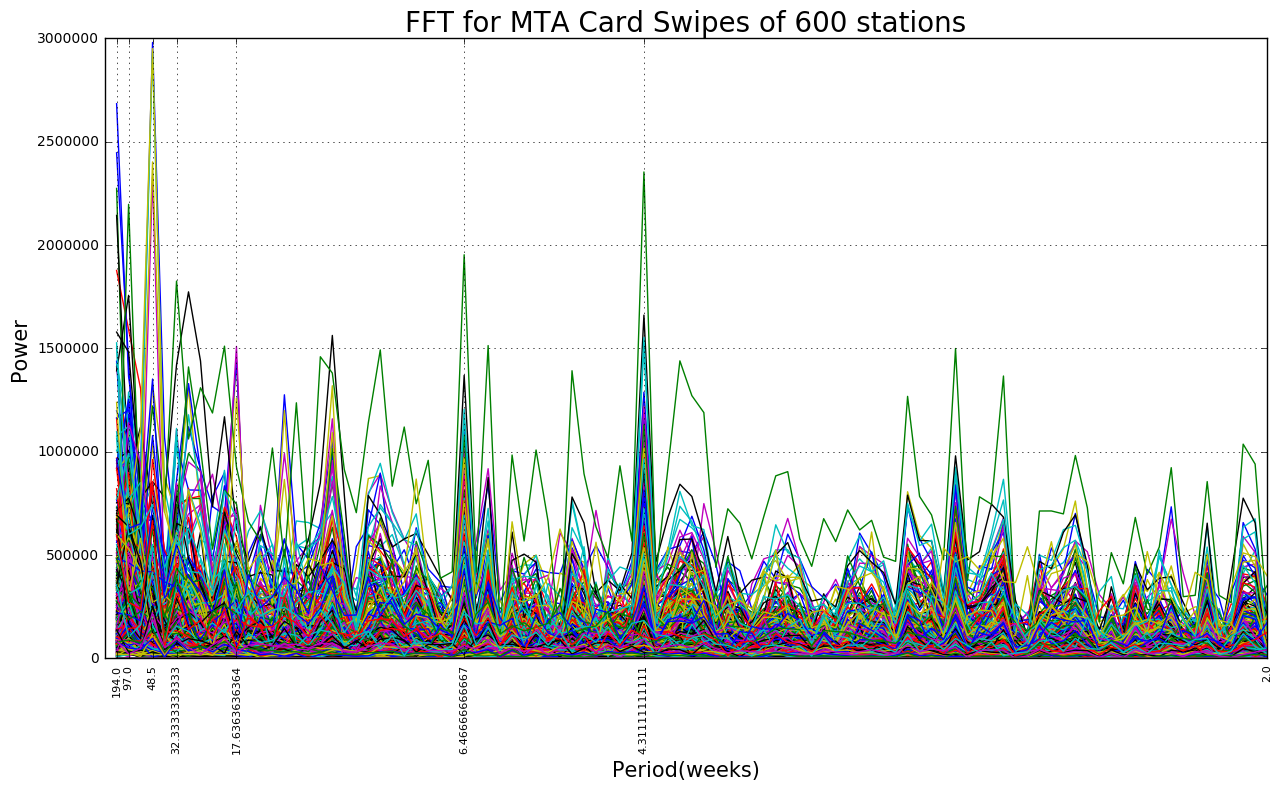

In [19]:
pl.figure(figsize=(15,8))
peak = []
xrange = np.fft.rfftfreq(194, 1)[1:]
for i in range(600):
    f = np.abs(np.fft.rfft(df3[i])[1:])
    peak.append(f[3])
    pl.plot(xrange, f)
xt = xrange[[0, 1, 3, 5, 10, 29, 44, -1]]
pl.xticks(xt, np.reciprocal(xt), fontsize=8, rotation=90)
pl.xlabel('Period(weeks)', fontsize=15)
pl.ylabel('Power', fontsize=15)
pl.title('FFT for MTA Card Swipes of 600 stations', fontsize=20)
pl.grid(True)
pl.show()

In [20]:
peak = np.array(peak)

In [21]:
sort = np.argsort(peak)[::-1]
mask = np.where(~np.isnan(peak[sort]))[0]
stations = sort[mask][:4]

In [22]:
print('The 4 station that show the most prominent periodic trend on an annual period')
pd.DataFrame(stations.T, columns=['Station index'])

The 4 station that show the most prominent periodic trend on an annual period


,Station index
0,0
1,194
2,150
3,327


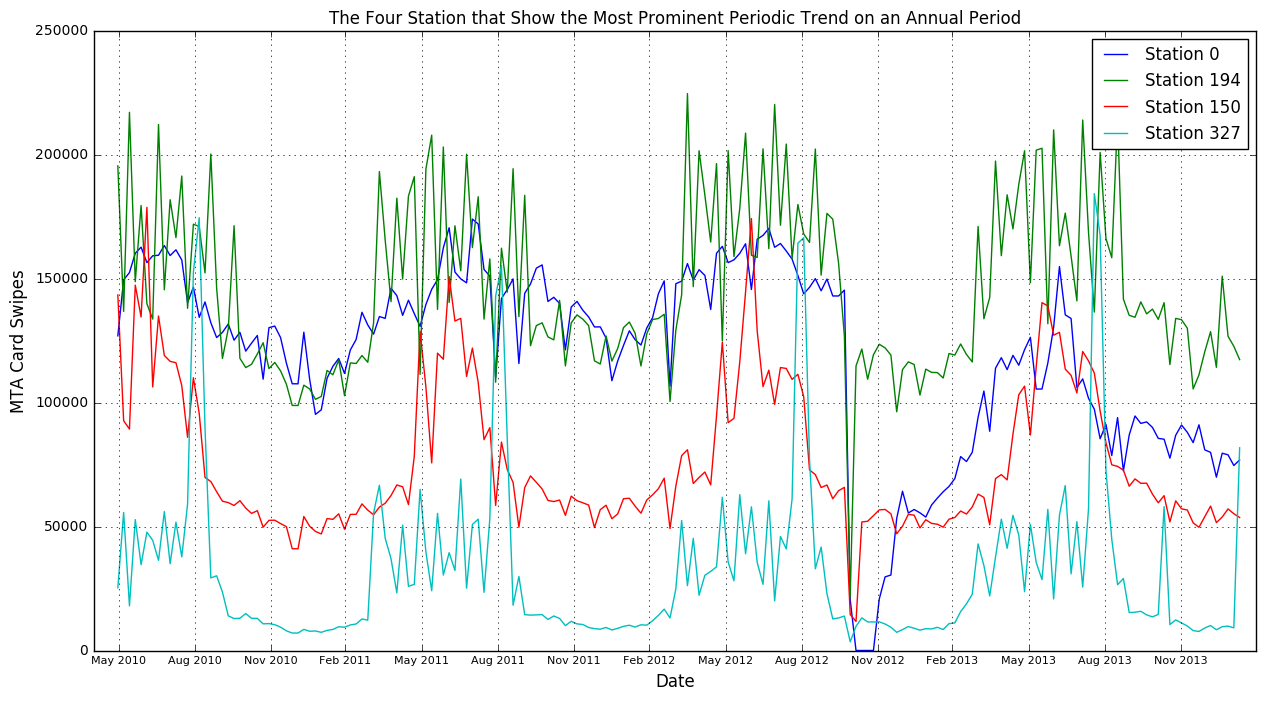

In [23]:
pl.figure(figsize=(15,8))
for i in stations:
    pl.plot(datelist, df3[i], label = "Station "+str(i))
pl.title("The Four Station that Show the Most Prominent Periodic Trend on an Annual Period")
pl.xlabel('Date', fontsize=12)
pl.ylabel('MTA Card Swipes', fontsize=12)
pl.xlim(dt.date(2010,5,1), dt.date(2014,3,1))
pl.xticks(daterange, DatetoStr(daterange), fontsize=8)
pl.legend(loc = "best")
pl.grid(True)
pl.show()

## EXTRA CREDIT: Cluster

In [24]:
tots = mtarides.transpose(2,0,1).reshape(mtarides.shape[2], mtarides.shape[1]*mtarides.shape[0]).T
tots = tots[tots.std(1)>0]
tots_vals = (tots - np.nanmean(tots, axis=0)) / np.nanstd(tots, axis=0)

### Choose the number of clusters. (k)
#### Silhouette Coefficient

In [25]:
def Silhouette_scores(X, range_n_clusters):
    for n_clusters in range_n_clusters:
        km = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = km.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

In [26]:
Silhouette_scores(tots_vals, range(2, 15))

For n_clusters =2, the average silhouette_score is :0.9236402879841956
For n_clusters =3, the average silhouette_score is :0.8933984603625201
For n_clusters =4, the average silhouette_score is :0.8814687050344748
For n_clusters =5, the average silhouette_score is :0.8671155127502798
For n_clusters =6, the average silhouette_score is :0.8596016039899624
For n_clusters =7, the average silhouette_score is :0.8595097450968571
For n_clusters =8, the average silhouette_score is :0.8450931118830164
For n_clusters =9, the average silhouette_score is :0.8253664646775822
For n_clusters =10, the average silhouette_score is :0.8246933072784404
For n_clusters =11, the average silhouette_score is :0.815814858219236
For n_clusters =12, the average silhouette_score is :0.8073443101355766
For n_clusters =13, the average silhouette_score is :0.8032598565089702
For n_clusters =14, the average silhouette_score is :0.7927265125372779


#### Elbow Method

In [27]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Average within-cluster sum of squares')
    pl.title('Elbow for KMeans clustering')
    pl.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = pl.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    pl.grid(True)
    pl.xlabel('Number of clusters')
    pl.ylabel('Percentage of variance explained')
    pl.title('Elbow for KMeans clustering')
    pl.show()

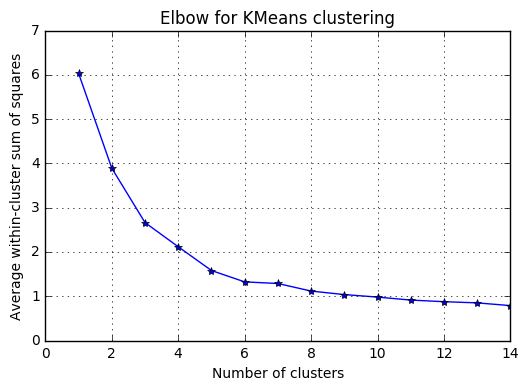

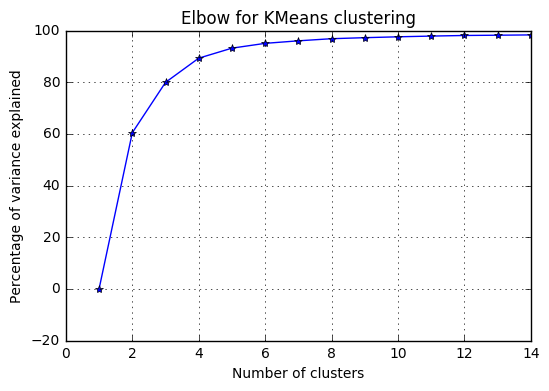

In [28]:
elbow(tots_vals, range(1,15))

### We should choose cluster number k = 6.

In [29]:
n = 6
km = KMeans(random_state=324,n_clusters=n)
res = km.fit(tots_vals)
reslabels = res.labels_

In [30]:
pca = PCA(194)
Xproj = pca.fit_transform(tots_vals)

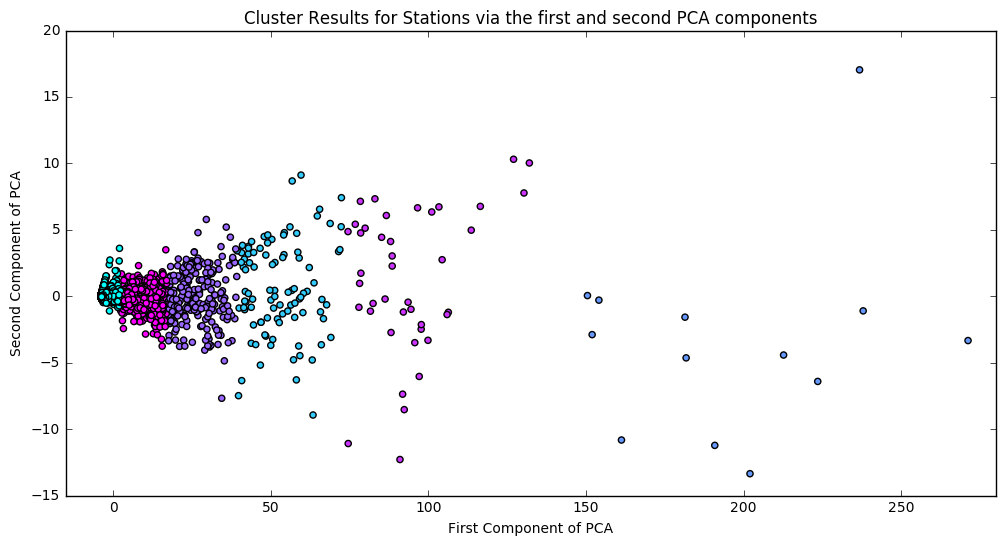

In [31]:
pl.figure(figsize=(12, 6))
pl.scatter(Xproj[:, 0], Xproj[:, 1], c=reslabels, cmap=pl.cm.cool)
pl.xlim(-15,280)
pl.xlabel('First Component of PCA')
pl.ylabel('Second Component of PCA')
pl.title("Cluster Results for Stations via the first and second PCA components")
pl.show()